In [1]:
# Imports and defaults
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
from scipy.optimize import linprog
import time

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 1.00
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 8
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
from tensorflow import keras

def linestyle2dashes(style):
  if style == "--":
    return (0, (3, 3))
  elif style == ":":
    return (0, (1, 3))
  else:
    return (None, None)

python 3.9.9
matplotlib 3.4.3
Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# MNIST
def pixelize(X, pixel=2):
  Xp = np.zeros((X.shape[0], X.shape[1] // pixel, X.shape[2] // pixel))
  for i in range(X.shape[1]):
    for j in range(X.shape[2]):
      Xp[:, i // pixel, j // pixel] += X[:, i, j]
  Xp /= pixel * pixel
  return Xp


def load_dataset(dataset):
  print("python %s" % platform.python_version())
  print("tf %s" % tf.__version__)
  print("keras %s" % keras.__version__)

  print("Preprocessing dataset %s..." % dataset)

  data_dir = ""
  if dataset == "iris":
    with gfile.Open("%s/%s.txt" % (data_dir, dataset)) as f:
      D = np.loadtxt(f, delimiter=",")
    X = D[:, : -1]
    y = D[:, -1]
  elif dataset == "letter_recognition":
    with gfile.Open("%s/%s.txt" % (data_dir, dataset)) as f:
      D = np.genfromtxt(f, dtype="str", delimiter=",")
    X = D[:, 1 :].astype(float)
    y = np.asarray(map(ord, D[:, 0]))
    y = y - y.min()
  elif dataset == "digit_recognition":
    with gfile.Open("%s/%s.txt" % (data_dir, dataset)) as f:
      D = np.loadtxt(f, delimiter=",")
    X = 2 * D[:, : -1] / 16 - 1  # [-1, 1] features
    y = D[:, -1]
  elif dataset == "mnist":
    (X, y), _ = keras.datasets.mnist.load_data()
    X = 2 * X.astype(float) / 255 - 1  # [-1, 1] features
    X = np.reshape(X, (X.shape[0], -1))
  elif dataset == "fashion_mnist":
    (X, y), _ = keras.datasets.fashion_mnist.load_data()
    X = 2 * X.astype(float) / 255 - 1  # [-1, 1] features
    X = np.reshape(X, (X.shape[0], -1))
  elif dataset == "cifar-10":
    with gfile.Open("%s/%s.txt" % (data_dir, dataset)) as f:
      D = np.loadtxt(f, delimiter=" ")
    X = D[:, : -1] / 255
    y = D[:, -1]

  print("%d examples, %d features, %d labels" %
    (X.shape[0], X.shape[1], y.max() + 1))

  return X, y

In [3]:
# Optimal designs
def a_grad(X, p, gamma=1e-6, return_grad=True):
  n, d = X.shape

  # inverse of the sample covariance matrix
  Xp = X * np.sqrt(p[:, np.newaxis])
  G = Xp.T.dot(Xp) + gamma * np.eye(d)
  invG = np.linalg.inv(G)

  # objective value (trace)
  obj = np.trace(invG)
  if return_grad:
    # gradient of the objective
    V = invG.dot(X.T)
    M = np.einsum("ik,jk->ijk", V, V)
    dp = - np.trace(M)
  else:
    dp = 0

  return obj, dp


def d_grad(X, p, gamma=1e-6, return_grad=True):
  n, d = X.shape

  # inverse of the sample covariance matrix
  Xp = X * np.sqrt(p[:, np.newaxis])
  G = Xp.T.dot(Xp) + gamma * np.eye(d)
  invG = np.linalg.inv(G)

  # objective value (log det)
  _, obj = np.linalg.slogdet(invG)
  if return_grad:
    # gradient of the objective
    V = np.einsum("ki,kj->ijk", X, X)
    M = np.einsum("ilk,lj->ijk", V, invG)
    dp = - np.trace(M)
  else:
    dp = 0

  return obj, dp


def e_grad(X, p, gamma=1e-6):
  n, d = X.shape

  # eigendecomposition of the sample covariance matrix
  Xp = X * np.sqrt(p[:, np.newaxis])
  G = Xp.T.dot(Xp) + gamma * np.eye(d)
  eigvals, eigv = np.linalg.eigh(G)

  v = eigv[:, 0]  # minimum eigenvector
  obj = - eigvals[0]  # objective value (- minimum eigenvalue)
  dp = - np.square(np.dot(X, v))  # gradient of the objective

  return obj, dp


def g_grad(X, p, gamma=1e-6):
  n, d = X.shape

  # inverse of the sample covariance matrix
  Xp = X * np.sqrt(p[:, np.newaxis])
  G = Xp.T.dot(Xp) + gamma * np.eye(d)
  invG = np.linalg.inv(G)

  # objective value
  obj = np.amax((X.dot(invG) * X).sum(axis=-1))

  # gradient of the objective
  xa = X[np.argmax((X.dot(invG) * X).sum(axis=-1)), :]
  dp = - np.square(xa.dot(invG).dot(X.T))

  return obj, dp


def fw_design(X, design="a", pi_0=None, num_iters=100, tol=1e-6, A_ub=None, b_ub=None, printout=True):
  n, d = X.shape

  if pi_0 is None:
    # initial allocation weights are 1 / n and they add up to 1
    pi = np.ones(n) / n
  else:
    pi = np.copy(pi_0)

  if (design == "e") or (design == "g"):
    pi = fw_design(X, "d", pi_0, num_iters, tol, A_ub, b_ub, printout)
    
  # initialize constraints
  if A_ub is None:
    A_ub_fw = np.ones((1, n))
    b_ub_fw = 1
  else:
    A_ub_fw = np.zeros((A_ub.shape[0] + 1, A_ub.shape[1]))
    A_ub_fw[: -1, :] = A_ub
    A_ub_fw[-1, :] = np.ones((1, n))
    b_ub_fw = np.zeros(b_ub.size + 1)
    b_ub_fw[: -1] = b_ub
    b_ub_fw[-1] = 1

  for iter in range(num_iters):
    # compute the gradient
    pi_last = np.copy(pi)
    if design == "a":
      last_obj, grad = a_grad(X, pi_last)
    elif design == "d":
      last_obj, grad = d_grad(X, pi_last)
    elif design == "g":
      last_obj, grad = g_grad(X, pi_last)
    else:
      last_obj, grad = e_grad(X, pi_last)

    if printout:
      print("%.4f" % last_obj, end=" ")

    # find a feasible LP solution in the direction of the gradient
    result = linprog(grad, A_ub_fw, b_ub_fw, bounds=[0, 1], method="revised simplex")
    pi_lp = result.x
    pi_lp = np.maximum(pi_lp, 0)
    pi_lp /= pi_lp.sum()

    # line search in the direction of the gradient
    num_ls_iters = 101
    best_step = 0.0
    best_obj = last_obj
    for ls_iter in range(num_ls_iters):
#       step = np.power(0.667, ls_iter)
      step = ls_iter / (num_ls_iters - 1)
      pi_ = step * pi_lp + (1 - step) * pi_last
      if design == "a":
        obj, _ = a_grad(X, pi_, return_grad=False)
      elif design == "d":
        obj, _ = d_grad(X, pi_, return_grad=False)
      elif design == "g":
        obj, _ = g_grad(X, pi_)
      else:
        obj, _ = e_grad(X, pi_)
      if obj < best_obj:
        best_step = step
        best_obj = obj

    # update solution
    pi = best_step * pi_lp + (1 - best_step) * pi_last

    if last_obj - best_obj < tol:
      break;
    iter += 1
  
  if printout:
    print()

  pi = np.maximum(pi, 0)
  pi /= pi.sum()
  return pi


def fw_safe_design(X, pi_0, alpha, theta_bar, Sigma_bar, num_iters=20):
  n, d = X.shape
  
  pi = fw_design(X, design="g", pi_0=pi_0, printout=False)
  A_ub = np.zeros((num_iters, n))
  b_ub = np.zeros(num_iters)
  
  iter = 1
  while iter < num_iters:
    # find the most violated reward constraint
    c = (alpha * pi_0 - pi).dot(X)
    theta = theta_bar + Sigma_bar.dot(c) / np.sqrt(c.dot(Sigma_bar.dot(c)))
    
    print("%d: %.4f, " % (iter, c.dot(theta)), end="")
    if c.dot(theta) < 1e-6:
      break;
    
    # expand reward constraint set
    A_ub[iter - 1, :] = - X.dot(theta)
    b_ub[iter - 1] = - alpha * pi_0.dot(X).dot(theta)
    pi = fw_design(X, design="g", pi_0=pi_0, A_ub=A_ub[: iter, :], b_ub=b_ub[: iter], printout=False)
    
    iter += 1
  print()

  return pi

python 3.9.9
tf 2.5.0
keras 2.5.0
Preprocessing dataset mnist...
60000 examples, 784 features, 10 labels
0.95
[ 6.9541709  14.84427001  7.03575676]
[0.13901251 2.47062338 0.29301207]
[ 0.14542675 -0.00211324 -0.00050738]
[0.23919485 0.48322249 0.25203191]
[0.05125116 0.09530021 0.0589743 ]


0.9
[ 6.92933255 13.48440081  7.03325783]
[0.14223276 1.61461358 0.25892   ]
[ 0.07441716 -0.00394141 -0.00113551]
[0.23584516 0.46288142 0.24430419]
[0.05316502 0.09554382 0.05524988]


0.85
[ 6.97227994 13.17389714  6.99210179]
[0.13021642 1.71492049 0.22895867]
[ 0.07721545 -0.0077765  -0.00041954]
[0.22875602 0.44560739 0.23571612]
[0.05771696 0.08587111 0.05973755]


0.8
[ 6.91852879 12.15740845  6.96330785]
[0.14470883 1.40152082 0.18478745]
[ 0.0701526  -0.01010163 -0.00247948]
[0.22906667 0.41114088 0.23359856]
[0.04648169 0.06360438 0.04911994]


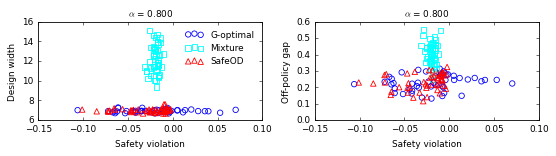

0.75
[ 6.98246413 11.96245327  7.00813434]
[0.13488975 1.006993   0.1989608 ]
[ 0.11869087 -0.01337589 -0.00309847]
[0.23857442 0.42561695 0.24348039]
[0.04549881 0.09180481 0.04202653]


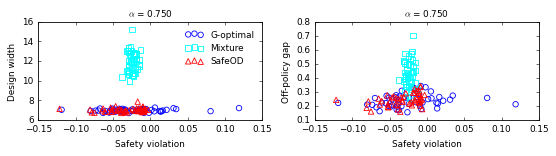

In [4]:
def single_run(run):
  width = np.zeros(3)
  reward_loss = np.zeros(3)
  gap = np.zeros(3)

  pos_label = run % 10  # digit with reward 1 (others have reward zero)

  # estimate \bar{\sigma} and \bar{\Sigma}
  yp = (y_mnist == pos_label).astype(int)
  Gram = X_mnist.T.dot(X_mnist) + 1e-3 * np.eye(d)
  theta_bar = np.linalg.solve(Gram, X_mnist.T.dot(yp))
  Sigma_bar = np.linalg.inv(Gram)

  yp = (y_mnist == pos_label).astype(int)
  print("Positive scores: %s" %
    " ".join("%.2f" % s for s in X_mnist.dot(theta_bar)[yp == 1][: 10]))
  print("Negative scores: %s" %
    " ".join("%.2f" % s for s in X_mnist.dot(theta_bar)[yp == 0][: 10]))

  # choose a subset of n arms
  X = X_mnist[np.random.randint(X_mnist.shape[0], size=n), :]
  pi_0 = np.random.dirichlet(alpha=np.ones(n))

  # optimal solution
  v = np.random.randn(d)
  v /= np.sqrt(np.square(v).sum())
  theta_star = theta_bar + sqrtm(Sigma_bar).dot(v)
  best_arm = np.argmax(X.dot(theta_star))

  for method in range(3):
    if method == 0:
      pi = fw_design(X, design="g", printout=False)
    elif method == 1:
      pi = alpha * pi_0 + (1 - alpha) / pi_0.size
    else:
      pi = fw_safe_design(X, pi_0, alpha, theta_bar, Sigma_bar)

    Xp = X * np.sqrt(pi[:, np.newaxis])
    G = Xp.T.dot(Xp) + 1e-3 * np.eye(d)
    invG = np.linalg.inv(G)
    width[method] = np.sqrt(np.amax((X.dot(invG) * X).sum(axis=-1)))

    # evaluate reward loss
    c = (alpha * pi_0 - pi).dot(X)
    map_reward_loss = c.dot(theta_bar)
    max_loss_theta = theta_bar + Sigma_bar.dot(c) / np.sqrt(c.dot(Sigma_bar.dot(c)))
    reward_loss[method] = c.dot(max_loss_theta)

    # evaluate off-policy optimization
    for i in range(1000):
      ndx = np.random.choice(n, size=10 * d, p=pi)
      X_off = X[ndx, :]
      y_off = X_off.dot(theta_star) + sigma * np.random.randn(ndx.size)
      G = X_off.T.dot(X_off) + 1e-3 * np.eye(d)
      theta = np.linalg.solve(G, X_off.T.dot(y_off))
      arm = np.argmax(X.dot(theta))
      gap[method] += (X[best_arm, :] - X[arm, :]).dot(theta_star)
    gap[method] /= 1000

  return width, reward_loss, gap


n = 100
num_runs = 50
sigma = 1.0  # reward noise

# create dataset
X_mnist, y_mnist = load_dataset("mnist")
imgs = np.reshape(X_mnist, (X_mnist.shape[0], 28, 28))  # original digits
# reshape digits to 7 x 7 (to speed up learning)
X_mnist = np.reshape(pixelize(imgs, pixel=4), (X_mnist.shape[0], 7 * 7))
d = X_mnist.shape[1]

for alpha in [0.95, 0.9, 0.85, 0.8, 0.75]:
  print(alpha)

  results = Parallel(n_jobs=-1)(delayed(single_run)(run) for run in range(num_runs))
  width = np.vstack(tuple(s[0] for s in results))
  reward_loss = np.vstack(tuple(s[1] for s in results))
  gap = np.vstack(tuple(s[2] for s in results))

  print(width[:, :].mean(axis=0))
  print(width[:, :].std(axis=0))
  print(reward_loss[:, :].max(axis=0))
  print(gap[:, :].mean(axis=0))
  print(gap[:, :].std(axis=0))

  plt.figure(figsize=(7, 2))

  plt.subplot(1, 2, 1)
  plt.scatter(reward_loss[:, 0], width[:, 0],
    s=24, marker="o", edgecolor="blue", facecolor="None",
    label="G-optimal")
  plt.scatter(reward_loss[:, 1], width[:, 1],
    s=24, marker="s", edgecolor="cyan", facecolor="None",
    label="Mixture")
  plt.scatter(reward_loss[:, 2], width[:, 2],
    s=24, marker="^", edgecolor="red", facecolor="None",
    label="SafeOD")
  plt.title(r"$\alpha$ = %.3f" % alpha)
  plt.xlabel("Safety violation")
  plt.ylabel("Design width")
  plt.legend(loc="upper right", frameon=False)

  plt.subplot(1, 2, 2)
  plt.scatter(reward_loss[:, 0], gap[:, 0],
    s=24, marker="o", edgecolor="blue", facecolor="None")
  plt.scatter(reward_loss[:, 1], gap[:, 1],
    s=24, marker="s", edgecolor="cyan", facecolor="None")
  plt.scatter(reward_loss[:, 2], gap[:, 2],
    s=24, marker="^", edgecolor="red", facecolor="None")
  plt.title(r"$\alpha$ = %.3f" % alpha)
  plt.xlabel("Safety violation")
  plt.ylabel("Off-policy gap")

  fname = "Results/mnist_alpha=%.3f" % alpha
  np.save(fname + "_width.npy", width)
  np.save(fname + "_reward_loss.npy", reward_loss)
  np.save(fname + "_gap.npy", gap)

  plt.tight_layout()
  plt.savefig(fname + ".pdf", format="pdf", dpi=1200, bbox_inches=0)
  plt.show()

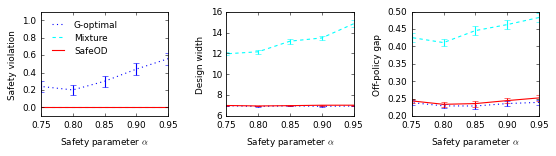

In [5]:
metrics = ["reward_loss", "width", "gap"]
labels = ["Safety violation", "Design width", "Off-policy gap"]
alpha = np.asarray([0.95, 0.9, 0.85, 0.8, 0.75])

plt.figure(figsize=(7, 2))

for i in range(3):
  plt.subplot(1, 3, i + 1)
  
  y = np.zeros((alpha.size, 3))
  std_y = np.zeros((alpha.size, 3))
  for j in range(alpha.size):
    D = np.load("Results/mnist_alpha=%.3f_%s.npy" % (alpha[j], metrics[i]))
    if i == 0:
      D = (D >= 1e-3)
    y[j, :] = D.mean(axis=0)
    std_y[j, :] = D.std(axis=0) / np.sqrt(D.shape[0])
  
  plt.plot(alpha, y[:, 0], "blue",
    linestyle=linestyle2dashes(":"),
    label="G-optimal" if i == 0 else "")
  plt.errorbar(alpha, y[:, 0], yerr=std_y[:, 0], ecolor="blue", fmt="none")
  plt.plot(alpha, y[:, 1], "cyan",
    linestyle=linestyle2dashes("--"),
    label="Mixture" if i == 0 else "")
  plt.errorbar(alpha, y[:, 1], yerr=std_y[:, 1], ecolor="cyan", fmt="none")
  plt.plot(alpha, y[:, 2], "red",
    label="SafeOD" if i == 0 else "")
  plt.errorbar(alpha, y[:, 2], yerr=std_y[:, 2], ecolor="red", fmt="none")
  
  plt.xlabel(r"Safety parameter $\alpha$")
  plt.ylabel(labels[i])
  if i == 0:
    plt.ylim(-0.1, 1.1)
    plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig("Results/mnist_alpha.pdf", format="pdf", dpi=1200, bbox_inches=0)
plt.show()